# 1. Preprocess data set and performing EDA

In this section we have described how we will preprocess data set by reading files from S3
- Input: S3 files in csv format 
- Output: Preprocess data which can be used for model training 

In [1]:
# Importing required library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import boto3

s3 = boto3.client('s3')


In [2]:
data = pd.read_csv("s3://ds-mlops-s3/data/input/inputdata.csv",
                   nrows=1000)# path of inoput %%file

In [3]:
df = data.copy()
df.head()

,Unnamed: 0,id,url,region,region_url,price,year,manufacturer,model,condition,...,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date
0,0,7240372487,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,35990,2010.0,chevrolet,corvette grand sport,good,...,rwd,NaN,other,NaN,https://images.craigslist.org/00N0N_ipkbHVZYf4...,Carvana is the safer way to buy a car During t...,al,32.590000,-85.480000,2020-12-02T08:11:30-0600
1,1,7240309422,https://auburn.craigslist.org/cto/d/auburn-201...,auburn,https://auburn.craigslist.org,7500,2014.0,hyundai,sonata,excellent,...,fwd,NaN,sedan,NaN,https://images.craigslist.org/00s0s_gBHYmJ5o7y...,I'll move to another city and try to sell my c...,al,32.547500,-85.468200,2020-12-02T02:11:50-0600
2,2,7240224296,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,4900,2006.0,bmw,x3 3.0i,good,...,NaN,NaN,SUV,blue,https://images.craigslist.org/00B0B_5zgEGWPOrt...,Clean 2006 BMW X3 3.0I. Beautiful and rare Bl...,al,32.616807,-85.464149,2020-12-01T19:50:41-0600
3,3,7240103965,https://auburn.craigslist.org/cto/d/lanett-tru...,auburn,https://auburn.craigslist.org,2000,1974.0,chevrolet,c-10,good,...,rwd,full-size,pickup,blue,https://images.craigslist.org/00M0M_6o7KcDpArw...,1974 chev. truck (LONG BED) NEW starter front ...,al,32.861600,-85.216100,2020-12-01T15:54:45-0600
4,4,7239983776,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,19500,2005.0,ford,f350 lariat,excellent,...,4wd,full-size,pickup,blue,https://images.craigslist.org/00p0p_b95l1EgUfl...,2005 Ford F350 Lariat (Bullet Proofed). This t...,al,32.547500,-85.468200,2020-12-01T12:53:56-0600


describing dataset which we have got

In [4]:
df.describe()

,Unnamed: 0,id,price,year,odometer,lat,long
count,1000.000000,1.000000e+03,1000.000000,994.000000,817.000000,993.000000,993.000000
mean,499.500000,7.236772e+09,16201.739000,2010.430584,104638.927785,34.104696,-87.182323
std,288.819436,2.705563e+06,13540.117434,7.223640,74516.810004,2.636793,7.701643
min,0.000000,7.224722e+09,0.000000,1955.000000,0.000000,1.241841,-122.509472
25%,249.750000,7.235471e+09,5575.000000,2007.000000,49245.000000,33.209824,-86.834600
50%,499.500000,7.236935e+09,12875.000000,2012.000000,98977.000000,33.520000,-86.783066
75%,749.250000,7.238693e+09,23996.250000,2015.000000,150000.000000,34.586557,-85.480000
max,999.000000,7.240596e+09,130000.000000,2020.000000,1000000.000000,47.313584,-74.281734


Removing unnessary columns

In [5]:
df.drop(columns=['Unnamed: 0', 'id', 'url', 'region', 'region_url', 'VIN', 'size', 'image_url', 'description', 'state', 'lat', 'long','posting_date'], inplace=True)

Imputing data for missing values

In [6]:
from sklearn.impute import SimpleImputer

imr = SimpleImputer(strategy='mean')
imr = imr.fit(df[['odometer']])
imputed_data = imr.transform(df[['odometer']])
df['odometer'] = pd.DataFrame(imputed_data)
df['odometer'].head()

0     32742.0
1     93600.0
2     87046.0
3    190000.0
4    116000.0
Name: odometer, dtype: float64

In [7]:
df['price'].value_counts

<bound method IndexOpsMixin.value_counts of 0      35990
1       7500
2       4900
3       2000
4      19500
       ...  
995     9400
996    15000
997        0
998    19995
999    25995
Name: price, Length: 1000, dtype: int64>

In [8]:
from sklearn import preprocessing

def encode_features(dataframe):
    result = dataframe.copy()
    encoders = {}
    for column in result.columns:
        if column=='year':
            result[column]=result[column]
            result[column].fillna(2018)
        elif result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders

encoded_df, encoders = encode_features(df) 
encoded_df=encoded_df[encoded_df['year']!='nan']
encoded_df.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color
0,35990,2010.0,5,147,2,4,2,32742.0,0,2,2,7,11
1,7500,2014.0,12,441,0,1,2,93600.0,0,0,1,9,11
2,4900,2006.0,2,517,2,3,2,87046.0,0,0,3,0,1
3,2000,1974.0,5,97,2,1,2,190000.0,0,0,2,8,1
4,19500,2005.0,9,237,0,4,0,116000.0,1,0,0,8,1


Features' hists plotted


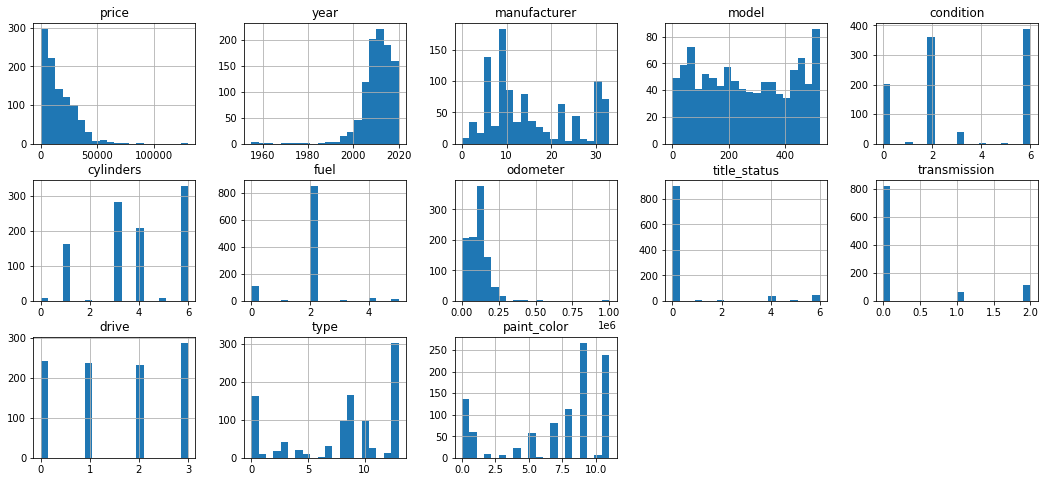

In [9]:
encoded_df.hist(figsize=(18, 8), layout=(3,5), bins=20)
print('Features\' hists plotted')

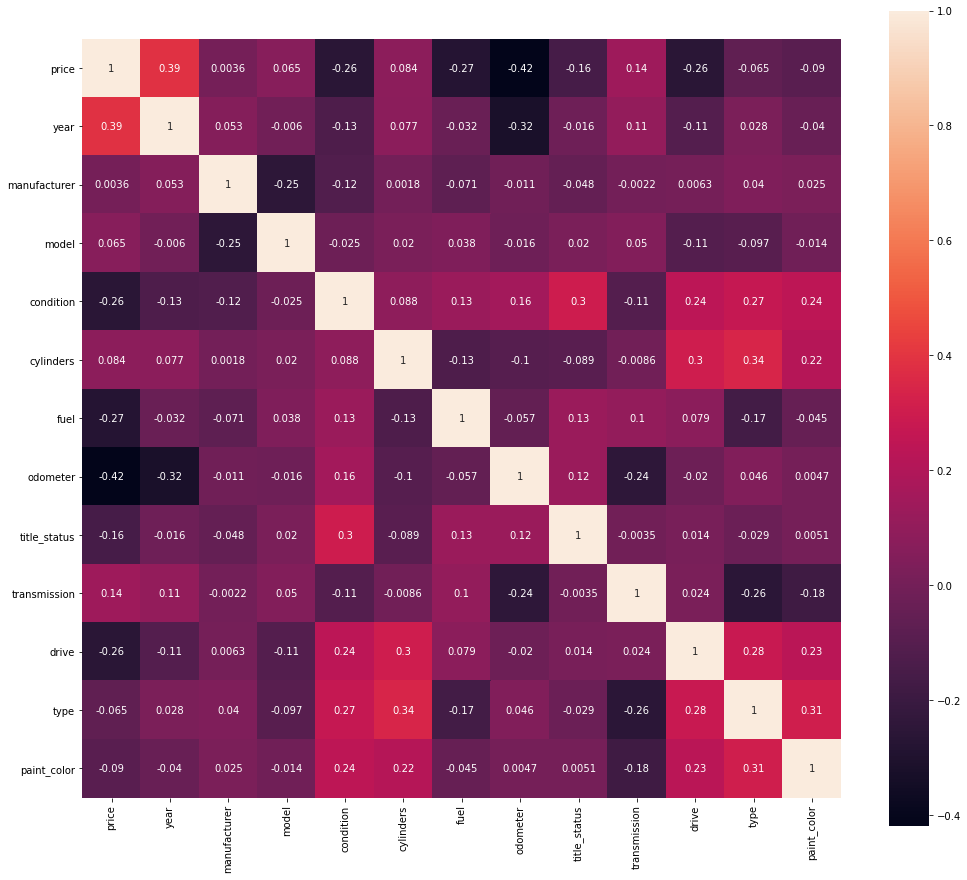

In [10]:
plt.subplots(figsize=(17, 15))
sns.heatmap(encoded_df.corr(), square = True, annot=True)
plt.show()

In [11]:
encoded_df.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color
0,35990,2010.0,5,147,2,4,2,32742.0,0,2,2,7,11
1,7500,2014.0,12,441,0,1,2,93600.0,0,0,1,9,11
2,4900,2006.0,2,517,2,3,2,87046.0,0,0,3,0,1
3,2000,1974.0,5,97,2,1,2,190000.0,0,0,2,8,1
4,19500,2005.0,9,237,0,4,0,116000.0,1,0,0,8,1


In [12]:
# encoded_df.to_csv('encoded_df.csv', encoding='utf-8')

In [13]:
encoded_df.fillna(method ='pad',inplace=True)

We'll then split the dataset into training (70%), validation (20%), and test (10%) datasets and convert the datasets to the right format the algorithm expects. We will use training and validation datasets during training. Test dataset will be used to evaluate model performance after it is deployed to an endpoint.

Amazon SageMaker's XGBoost algorithm expects data in the libSVM or CSV data format.  For this example, we'll stick to CSV.  Note that the first column must be the target variable and the CSV should not include headers.  Also, notice that although repetitive it's easiest to do this after the train|validation|test split rather than before.  This avoids any misalignment issues due to random reordering.

In [14]:
train_data, validation_data, test_data = np.split(encoded_df.sample(frac=1, random_state=1729), [int(0.7 * len(encoded_df)), int(0.9*len(encoded_df))])  

In [15]:
train_data.shape

(700, 13)

In [16]:
validation_data.shape

(200, 13)

In [17]:
test_data.shape

(100, 13)

**Exporting data set to s3 bucket without header**

In [18]:
# train_data.to_csv('s3://ds-mlops-s3/preprocess-data/vci/data/input/lrtrain/train.csv', index=False, header=False)
# validation_data.to_csv('s3://ds-mlops-s3/preprocess-data/vci/data/input/lrvalidation/validation_data.csv', index=False, header=False)
# test_data.to_csv('s3://ds-mlops-s3/preprocess-data/vci/data/input/lrtest/test.csv', index=False, header=False)


train_data.to_csv('s3://ds-mlops-s3/preprocess-data/train/train.csv', index=False, header=False)
validation_data.to_csv('s3://ds-mlops-s3/preprocess-data/validation/validation_data.csv', index=False, header=False)
test_data.to_csv('s3://ds-mlops-s3/preprocess-data/test/test.csv', index=False, header=False)




## 2. Building model

In this section we will decribe how we will build model with XGboost inbuilt model and here we will pass hyperparameter to train our model

In [19]:
# Importing the required libraries
import boto3
import time
from time import gmtime, strftime
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri
import datetime
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.inputs import TrainingInput

# hyper
job_name = 'ds-mlops-linear-learner' + str(datetime.datetime.now().timestamp()).split('.')[0]

# sagemaker
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

#ec2
Instance_Type = "ml.m5.xlarge"
VolumeSizeIn_GB = 1
Instance_Count = 1

#setup container
container = get_image_uri(region, "linear-learner")

#s3
bucket = 'ds-mlops-s3'
prefix = "ds-mlops-s3/preprocess-data"
# 
#input
data_bucket = bucket
data_prefix = prefix
data_bucket_path = f"s3://{data_bucket}"

# S3 bucket for saving code and model artifacts.
# output
output_bucket = sagemaker.Session().default_bucket()
output_prefix = 'ds-mlops-s3/output'
output_bucket_path = f"s3://{output_bucket}"   
sec_groups = ["sg-0606c76de3d41b40a"]
subnets = ["subnet-07bd1dfe6aee76227",
           "subnet-076950ecc89d4340b",
           "subnet-0c5a462cb45a14bab"]

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


---

## Setup_Hyperparameter_Tuning 
*Note, with the default setting below, the hyperparameter tuning job can take about 30 minutes to complete.*


Now that we have prepared the dataset, we are ready to train models. Before we do that, one thing to note is there are algorithm settings which are called "hyperparameters" that can dramtically affect the performance of the trained models. For example, XGBoost algorithm has dozens of hyperparameters and we need to pick the right values for those hyperparameters in order to achieve the desired model training results. Since which hyperparameter setting can lead to the best result depends on the dataset as well, it is almost impossible to pick the best hyperparameter setting without searching for it, and a good search algorithm can search for the best hyperparameter setting in an automated and effective way.

We will use SageMaker hyperparameter tuning to automate the searching process effectively. Specifically, we specify a range, or a list of possible values in the case of categorical hyperparameters, for each of the hyperparameter that we plan to tune. SageMaker hyperparameter tuning will automatically launch multiple training jobs with different hyperparameter settings, evaluate results of those training jobs based on a predefined "objective metric", and select the hyperparameter settings for future attempts based on previous results. For each hyperparameter tuning job, we will give it a budget (max number of training jobs) and it will complete once that many training jobs have been executed.

In this example, we are using SageMaker Python SDK to set up and manage the hyperparameter tuning job. We first configure the training jobs the hyperparameter tuning job will launch by initiating an estimator, which includes:
* The container image for the algorithm (XGBoost)
* Configuration for the output of the training jobs
* The values of static algorithm hyperparameters, those that are not specified will be given default values
* The type and number of instances to use for the training jobs

In [20]:
#setup sagemaker SDK
client = boto3.client("sagemaker", region_name=region)

In [21]:
sess = sagemaker.Session()
linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       instance_count = 1, 
                                       instance_type = 'ml.c4.xlarge',
                                       output_path = output_bucket_path,
                                       sagemaker_session = sess)

linear.set_hyperparameters(
                           predictor_type = 'regressor',
                           mini_batch_size = 20,
                           epochs = 5,
                           num_models = 10,
                           loss = 'absolute_loss')

We will tune four hyperparameters in this examples:
* *eta*: Step size shrinkage used in updates to prevent overfitting. After each boosting step, you can directly get the weights of new features. The eta parameter actually shrinks the feature weights to make the boosting process more conservative. 
* *alpha*: L1 regularization term on weights. Increasing this value makes models more conservative. 
* *min_child_weight*: Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, the building process gives up further partitioning. In linear regression models, this simply corresponds to a minimum number of instances needed in each node. The larger the algorithm, the more conservative it is. 
* *max_depth*: Maximum depth of a tree. Increasing this value makes the model more complex and likely to be overfitted. 

In [22]:
hyperparameter_ranges = {'mini_batch_size': CategoricalParameter([32,64,128,256,512]),
                        'learning_rate': ContinuousParameter(0.0001, 1),
                        'l1': ContinuousParameter(0.0001, 1)
                        }

Next we'll specify the objective metric that we'd like to tune and its definition, which includes the regular expression (Regex) needed to extract that metric from the CloudWatch logs of the training job. Since we are using built-in XGBoost algorithm here, it emits two predefined metrics: *validation:auc* and *train:auc*, and we elected to monitor *validation:auc* as you can see below. In this case, we only need to specify the metric name and do not need to provide regex. If you bring your own algorithm, your algorithm emits metrics by itself. In that case, you'll need to add a MetricDefinition object here to define the format of those metrics through regex, so that SageMaker knows how to extract those metrics from your CloudWatch logs.

In [23]:
objective_metric_name = 'validation:objective_loss:final'
objective_type = 'Minimize'

Now, we'll create a `HyperparameterTuner` object, to which we pass:
- The XGBoost estimator we created above
- Our hyperparameter ranges
- Objective metric name and definition
- Tuning resource configurations such as Number of training jobs to run in total and how many training jobs can be run in parallel.

In [24]:
tuner = HyperparameterTuner(linear,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=1,
                            max_parallel_jobs=1,
                            early_stopping_type='Auto',
                            objective_type=objective_type)

## Launch_Hyperparameter_Tuning
Now we can launch a hyperparameter tuning job by calling *fit()* function. After the hyperparameter tuning job is created, we can go to SageMaker console to track the progress of the hyperparameter tuning job until it is completed.

In [25]:
print('{}/{}/lrtrain/train.csv'.format(data_bucket_path, data_prefix))
print('{}/{}/lrvalidation/validation_data.csv'.format(data_bucket_path, data_prefix))

s3://ds-mlops-s3/ds-mlops-s3/preprocess-data/lrtrain/train.csv
s3://ds-mlops-s3/ds-mlops-s3/preprocess-data/lrvalidation/validation_data.csv


In [26]:
s3_input_train = TrainingInput(s3_data='{}/preprocess-data/train/train.csv'.format(data_bucket_path, data_prefix), content_type='text/csv')
s3_input_validation = TrainingInput(s3_data='{}/preprocess-data/validation/validation_data.csv'.format(data_bucket_path, data_prefix), content_type='text/csv')
tuner.fit({'train': s3_input_train, 'validation': s3_input_validation}, include_cls_metadata=False)



...........................................!


Let's just run a quick check of the hyperparameter tuning jobs status to make sure it started successfully.

In [27]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'Completed'

In [28]:
print(data_bucket_path,data_prefix)

s3://ds-mlops-s3 ds-mlops-s3/preprocess-data


In [29]:
tuning_job_name = tuner.latest_tuning_job.job_name # Get name of hpo job

# Analyze Results of a Hyperparameter Tuning job

Once you have completed a tuning job, (or even while the job is still running) you can use this notebook to analyze the results to understand how each hyperparameter effects the quality of the model.


## Track hyperparameter tuning job progress and print best result
After you launch a tuning job, you can see its progress by calling describe_tuning_job API. The output from describe-tuning-job is a JSON object that contains information about the current state of the tuning job. You can call list_training_jobs_for_tuning_job to see a detailed list of the training jobs that the tuning job launched.

In [30]:
# run this cell to check current status of hyperparameter tuning job
region = boto3.Session().region_name
sage_client = boto3.Session().client('sagemaker')
tuning_job_result = sage_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)


status = tuning_job_result['HyperParameterTuningJobStatus']
if status != 'Completed':
    print('Reminder: the tuning job has not been completed.')
    
job_count = tuning_job_result['TrainingJobStatusCounters']['Completed']
print("%d training jobs have completed" % job_count)

best_hyper_parameter = tuning_job_result['BestTrainingJob']['TunedHyperParameters']
print("Best performing hyper parameters :",best_hyper_parameter)

result = tuning_job_result['BestTrainingJob']['FinalHyperParameterTuningJobObjectiveMetric']
print("Result : ",result)

1 training jobs have completed
Best performing hyper parameters : {'l1': '0.04580626658504098', 'learning_rate': '0.00033871082132064814', 'mini_batch_size': '512'}
Result :  {'MetricName': 'validation:objective_loss:final', 'Value': 10717.4111328125}


In [31]:
ll_best_hyper_parameter = best_hyper_parameter

In [32]:
print(ll_best_hyper_parameter['l1'],ll_best_hyper_parameter['learning_rate'],ll_best_hyper_parameter['mini_batch_size'])
print(ll_best_hyper_parameter)

0.04580626658504098 0.00033871082132064814 512
{'l1': '0.04580626658504098', 'learning_rate': '0.00033871082132064814', 'mini_batch_size': '512'}


In [33]:
%store ll_best_hyper_parameter

Stored 'll_best_hyper_parameter' (dict)


**Creating model for Linear Learner by passing hyper parameter**

Once we have tunned parameter we will generate our model for scoring activities on sagemaker

In [34]:
{output_bucket_path},{output_prefix}

({'s3://sagemaker-us-east-1-014257795134'}, {'ds-mlops-s3/output'})

In [35]:
%%time

print("Training job", job_name)

# Ensure that the training and validation data folders generated above are reflected in the "InputDataConfig" parameter below.
create_training_params = {
    "AlgorithmSpecification": {"TrainingImage": container, "TrainingInputMode": "File"},
    "RoleArn": role,
    "OutputDataConfig": {"S3OutputPath": f"{output_bucket_path}/{output_prefix}/output"},
    "ResourceConfig": {"InstanceCount": Instance_Count, "InstanceType": Instance_Type, "VolumeSizeInGB": VolumeSizeIn_GB},
    "VpcConfig": { 
              "SecurityGroupIds": sec_groups,
              "Subnets": subnets
   },
    "TrainingJobName": job_name,
    "HyperParameters": {"predictor_type" :'regressor',
                        "epochs":"20",
                        "l1":ll_best_hyper_parameter['l1'],
                        "learning_rate":ll_best_hyper_parameter['learning_rate'],
                        "mini_batch_size":ll_best_hyper_parameter['mini_batch_size']
                       },
    "StoppingCondition": {"MaxRuntimeInSeconds": 3600},
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": f"s3://ds-mlops-s3/preprocess-data/train/train.csv",
                    "S3DataDistributionType": "FullyReplicated",
                }
            },
            "ContentType": "text/csv",
            "CompressionType": "None",
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri":f"s3://ds-mlops-s3/preprocess-data/validation/validation_data.csv",
                    "S3DataDistributionType": "FullyReplicated",
                }
            },
            "ContentType": "text/csv",
            "CompressionType": "None",
            
        },
    ],
}

client.create_training_job(**create_training_params)

#track execution
status = client.describe_training_job(TrainingJobName=job_name)["TrainingJobStatus"]
print(status)
while status != "Completed" and status != "Failed":
    time.sleep(180)
    status = client.describe_training_job(TrainingJobName=job_name)["TrainingJobStatus"]
    print(status)

Training job ds-mlops-linear-learner1648440170
InProgress
Completed
CPU times: user 47.7 ms, sys: 1.06 ms, total: 48.7 ms
Wall time: 3min 2s


In [36]:
# checking training job status after creating training job
status = client.describe_training_job(TrainingJobName=job_name)["TrainingJobStatus"]
print(status)

Completed


In [37]:
# printing model output location
print(f"model path: >> {output_bucket_path}/{output_prefix}/output")

model path: >> s3://sagemaker-us-east-1-014257795134/ds-mlops-s3/output/output


In [38]:
# printing the training metrics you can tune and generate model as per need
metrics = client.describe_training_job(TrainingJobName=job_name)["FinalMetricDataList"]
print(metrics)

[{'MetricName': 'train:progress', 'Value': 100.0, 'Timestamp': datetime.datetime(2022, 3, 28, 4, 11, 11, tzinfo=tzlocal())}, {'MetricName': 'validation:mae', 'Value': 8245.83203125, 'Timestamp': datetime.datetime(2022, 3, 28, 4, 11, 11, tzinfo=tzlocal())}, {'MetricName': 'train:objective_loss', 'Value': 1.0832200050354004, 'Timestamp': datetime.datetime(2022, 3, 28, 4, 11, 11, tzinfo=tzlocal())}, {'MetricName': 'validation:objective_loss', 'Value': 176831680.0, 'Timestamp': datetime.datetime(2022, 3, 28, 4, 11, 11, tzinfo=tzlocal())}, {'MetricName': 'validation:objective_loss:final', 'Value': 121789624.0, 'Timestamp': datetime.datetime(2022, 3, 28, 4, 11, 11, tzinfo=tzlocal())}, {'MetricName': 'validation:rmse', 'Value': 11035.833984375, 'Timestamp': datetime.datetime(2022, 3, 28, 4, 11, 11, tzinfo=tzlocal())}, {'MetricName': 'validation:mse', 'Value': 121789624.0, 'Timestamp': datetime.datetime(2022, 3, 28, 4, 11, 11, tzinfo=tzlocal())}, {'MetricName': 'validation:r2', 'Value': 0.2664

In [39]:
# finding job name 
print(job_name)

ds-mlops-linear-learner1648440170


**Note:** you will need folowing values in next section
- hyperparameter
- training job name

## 3. Generate model on Sagemaker

In section we will describe how we can create a model with our training jobs

In [40]:
import sys
import math
import boto3
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri
from time import gmtime, strftime

model_name = 'ds-mlops-linear-learner' # It need to be unique across the account

role = sagemaker.get_execution_role()
region = boto3.Session().region_name
runtime_client = boto3.client("runtime.sagemaker", 
                              region_name=region)
client = boto3.client("sagemaker", 
                      region_name=region)

Check if model with same name exists or not. If it exist then delete it.

In [41]:
client = boto3.client('sagemaker') # getting sagemaker client 
try:
    client.delete_model(
        ModelName=model_name # delete if some model exist with this name
    )
except:
    pass

In [42]:
container = get_image_uri(region, "linear-learner") # getting container image

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


**Register model**


In [43]:
# Here we are registering our model
print(model_name) 
info = client.describe_training_job(TrainingJobName=job_name)
model_data = info["ModelArtifacts"]["S3ModelArtifacts"]
print(model_data)
primary_container = {"Image": container, "ModelDataUrl": model_data}
create_model_response = client.create_model(
    ModelName=model_name, 
    ExecutionRoleArn=role, 
    PrimaryContainer=primary_container,
    VpcConfig={
            'SecurityGroupIds':sec_groups,
            'Subnets': subnets
            }
)
print(create_model_response["ModelArn"]) # printing model ARN which is cretaed

ds-mlops-linear-learner
s3://sagemaker-us-east-1-014257795134/ds-mlops-s3/output/output/ds-mlops-linear-learner1648440170/output/model.tar.gz
arn:aws:sagemaker:us-east-1:014257795134:model/ds-mlops-linear-learner


In [44]:
print(model_name)

ds-mlops-linear-learner


**Note :** 
- We will need this model ARN for generating endpoint 
- Also model name need to be unique in an aws account
- In case if we need to regenerate model we have to delete existing model

## 4. Delete endpoint config

In [157]:
import sys
import math
import boto3
import sagemaker
from time import gmtime, strftime

role = sagemaker.get_execution_role()
region = boto3.Session().region_name
runtime_client = boto3.client("runtime.sagemaker", region_name=region)
client = boto3.client("sagemaker", region_name=region)
endpoint_config_name = 'ds-mlops-linear-learner-endpoint-config'

In [158]:
client = boto3.client('sagemaker') # getting sagemaker client 
try:
    client.delete_endpoint_config(
     EndpointConfigName=endpoint_config_name
    )
except:
    pass


## 5. Create endpoint config
In this section we will describe how we can create a model endpoint.

For generating sagemaker end point we will need to generate endpoint config. So generating endpoint config first

In [154]:
import sys
import math
import boto3
import sagemaker
from time import gmtime, strftime

endpoint_config_name = 'ds-mlops-linear-learner-endpoint-config'

role = sagemaker.get_execution_role()
region = boto3.Session().region_name
runtime_client = boto3.client("runtime.sagemaker", region_name=region)
client = boto3.client("sagemaker", region_name=region)

In [155]:
# Instance config for endpoint
Instance_Type = "ml.m5.xlarge"
VolumeSizeIn_GB = 20
Instance_Count = 1

In [159]:
# Creating endpoint config
print(endpoint_config_name)
create_endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": Instance_Type,
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "ModelName": model_name,
            "VariantName": "AllTraffic",
        }
    ],
    DataCaptureConfig={
        'EnableCapture': True,
        'InitialSamplingPercentage': 100,
        'DestinationS3Uri': 's3://ds-mlops-s3/data/capture',
        'CaptureOptions': [
            {
                'CaptureMode': 'Input'
            },
             {
                'CaptureMode': 'Output'
            },
        ],
        'CaptureContentTypeHeader': {
            'CsvContentTypes': [
                'text/csv',
            ],
            'JsonContentTypes': [
                'application/json',
            ]
        }        
    }
)

print(f"Endpoint Config Arn: {create_endpoint_config_response['EndpointConfigArn']}")

ds-mlops-linear-learner-endpoint-config
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:014257795134:endpoint-config/ds-mlops-linear-learner-endpoint-config


**Note :** We will use able endpoint config name to cretae model endpoint

Incase if you want to delete endpoint config and recreate it we can use below code snippet

## 6.Create Endpoint

In this notebook we create endpoint using endpoint which we have created

In [160]:
#delete existing end point
endpoint_name = 'ds-mlops-linear-learner-endpoint'
client = boto3.client('sagemaker') # getting sagemaker client 
try:
    client.delete_endpoint(
     EndpointName=endpoint_name
    )
except:
    pass


In [161]:
# Importing required library
import sys
import math
import boto3
import sagemaker
import time    

role = sagemaker.get_execution_role()
region = boto3.Session().region_name
runtime_client = boto3.client("runtime.sagemaker", region_name=region)
client = boto3.client("sagemaker", region_name=region)
endpoint_name = 'ds-mlops-linear-learner-endpoint' # name of model endpoint

In [162]:
# Creating model endpoint
print(endpoint_name)
create_endpoint_response = client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)
print(create_endpoint_response["EndpointArn"])

resp = client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
while status == "Creating":
    print(f"Status: {status}")
    time.sleep(60)
    resp = client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]

print(f"Arn: {resp['EndpointArn']}")
print(f"Status: {status}")

ds-mlops-linear-learner-endpoint
arn:aws:sagemaker:us-east-1:014257795134:endpoint/ds-mlops-linear-learner-endpoint
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Arn: arn:aws:sagemaker:us-east-1:014257795134:endpoint/ds-mlops-linear-learner-endpoint
Status: InService


## 7. Validate scoring

In this section we will validate scoring logics. In below code snippet we are scoring with 14 predictor values and finding the result

In [163]:
import boto3
import json

client = boto3.client('sagemaker-runtime')
test_vector = [2018.0,5,147,2,4,2,2000,0,2,0,7,0]

body = ','.join([str(item) for item in test_vector])
response = client.invoke_endpoint(EndpointName=endpoint_name,
                               ContentType='text/csv',
                               Body=body)
print(response["Body"].read())

b'{"predictions": [{"score": 29871.4375}]}'


**Note:** Similarly you can change the test vector and can see how endpoint is working

**References** <br/>
- How to configure preprocessing jobs on step function (https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateProcessingJob.html)
- How to create batch transform jobs
(https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateTransformJob.html)
- Create training jobs
(https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateTrainingJob.html)
- In case if team wants to bring any sagemaker component
(https://docs.aws.amazon.com/step-functions/latest/dg/connect-sagemaker.html)
- How to create lambda using state function
(https://docs.aws.amazon.com/step-functions/latest/dg/tutorial-creating-lambda-state-machine.html)

In [ ]:
#Clean up-- delete end point-


In [164]:
client = boto3.client("sagemaker", region_name=region)
response=client.delete_endpoint(EndpointName=endpoint_name)